In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
def process_image_with_border(image_path, target_size=(512, 512), inner_size=(400, 400), pad_color=(255, 255, 255)):
    img = Image.open(image_path).convert("RGB") 
    width, height = img.size

    # Determine cropping box
    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side

    # Crop to square
    img = img.crop((left, top, right, bottom))

    # Resize to inner size 
    img = img.resize(inner_size, Image.LANCZOS)

    # Create a blank white background
    new_img = Image.new("RGB", target_size, pad_color)

    # Paste resized image centered on the white background
    paste_x = (target_size[0] - inner_size[0]) // 2
    paste_y = (target_size[1] - inner_size[1]) // 2
    new_img.paste(img, (paste_x, paste_y))

    return new_img

In [3]:
# Define paths
base_dir = "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version"
fire_dir = os.path.join(base_dir, "train/fire")
nofire_dir = os.path.join(base_dir, "train/nofire")

# Get list of image filenames
fire_images = sorted(os.listdir(fire_dir))[:3]  
nofire_images = sorted(os.listdir(nofire_dir))[:3]

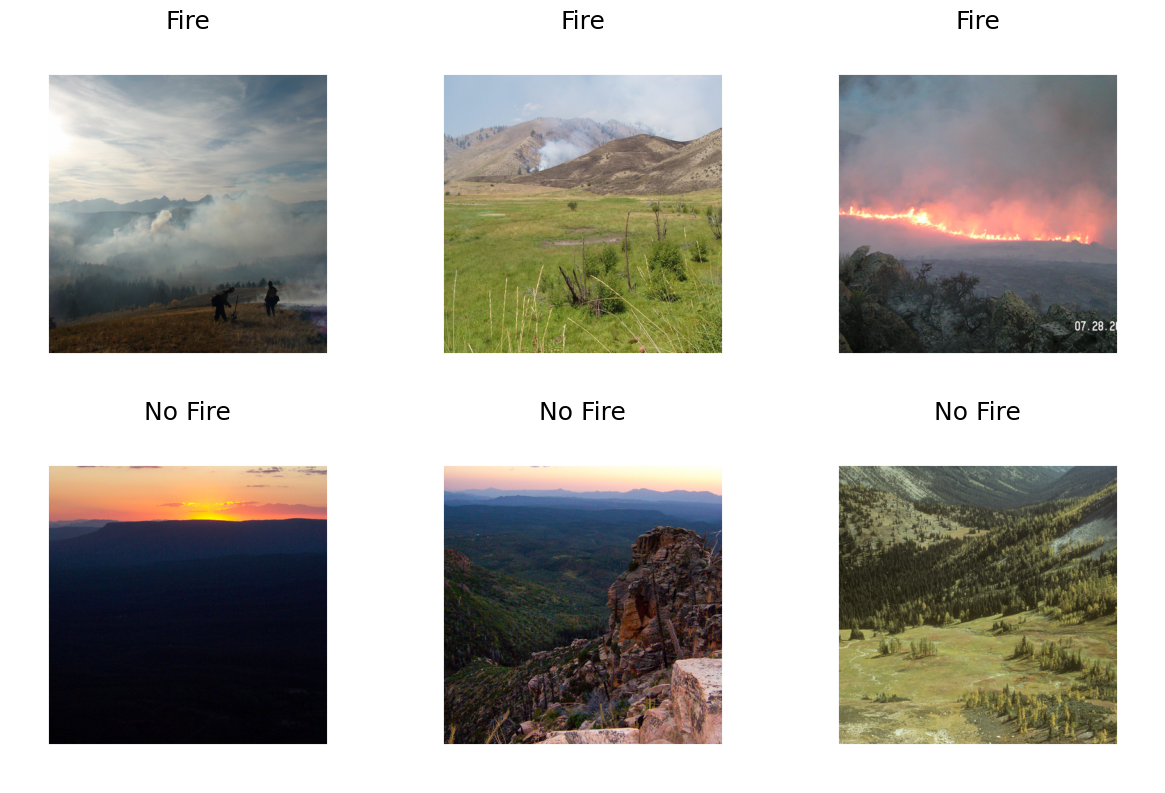

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Process and display images with borders
for i, img_name in enumerate(fire_images):
    img_path = os.path.join(fire_dir, img_name)
    img = process_image_with_border(img_path)  
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Fire", fontsize=18)

for i, img_name in enumerate(nofire_images):
    img_path = os.path.join(nofire_dir, img_name)
    img = process_image_with_border(img_path) 
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("No Fire", fontsize=18)

plt.tight_layout()
plt.show()

In [5]:
# Define dataset paths
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

In [6]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
SEED = 1234

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)


normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1887 files belonging to 2 classes.
Found 402 files belonging to 2 classes.
Found 410 files belonging to 2 classes.


In [8]:
def load_model_info(filepath, model_name):
    with open(filepath, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame([data])
    df.insert(0, "Model Name", model_name)  # Insert model name as first column
    return df

# Load all models
models = [
    ("BaselineCNN", "/kaggle/input/baselinecnn/saved_models/best_model_info.json"),
    ("MobileNetV2", "/kaggle/input/mobilenetv2/saved_models/best_model_info.json"),
    ("DenseNet121", "/kaggle/input/densenet121/saved_models/best_model_info.json"),
    ("NASNetMobile", "/kaggle/input/nasnetmobile/saved_models/best_model_info.json"),
    ("EfficientNet-B0", "/kaggle/input/efficientnet-b0/saved_models/best_model_info.json"),
    ("ResNet50", "/kaggle/input/resnet50/saved_models/best_model_info.json"),
]

# Concatenate all model DataFrames
df_models = pd.concat([load_model_info(path, name) for name, path in models], ignore_index=True)

df_models = df_models[["Model Name", "Train Accuracy", "Val Accuracy", "Test Accuracy"]]
df_models

,Model Name,Train Accuracy,Val Accuracy,Test Accuracy
0,BaselineCNN,0.839958,0.798507,0.826829
1,MobileNetV2,0.846317,0.833333,0.853659
2,DenseNet121,0.969793,0.885572,0.917073
3,NASNetMobile,0.941706,0.860696,0.878049
4,EfficientNet-B0,0.613143,0.611940,0.612195
5,ResNet50,0.793323,0.736318,0.804878


In [9]:
# Function to evaluate the model and return TP, FP, TN, FN counts
def evaluate_model(model_path, model_name, test_ds):
    print(f"Processing {model_name}...")  # Print model processing status
    model = tf.keras.models.load_model(model_path)  # Load model
    
    y_true_list, y_pred_probs_list = [], []

    for images, labels in test_ds:
        y_true_list.append(labels.numpy())  # Store true labels
        y_pred_probs_list.append(model.predict(images, verbose=0))  # Store predictions

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)

    # Convert probabilities to binary labels
    y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Create DataFrame
    df_cm = pd.DataFrame([[model_name, tp, fp, tn, fn]], 
                         columns=["Model", "True Positives (TP)", "False Positives (FP)", 
                                  "True Negatives (TN)", "False Negatives (FN)"])

    return df_cm


In [10]:
# Define model paths and names
model_paths = {
    "BaselineCNN": "/kaggle/input/baselinecnn/saved_models/best_model.keras",
    "MobileNetV2": "/kaggle/input/mobilenetv2/saved_models/best_model.keras",
    "DenseNet121": "/kaggle/input/densenet121/saved_models/best_model.keras",
    "NASNetMobile": "/kaggle/input/nasnetmobile/saved_models/best_model.keras",
    "EfficientNet-B0": "/kaggle/input/efficientnet-b0/saved_models/best_model.keras",
    "ResNet50": "/kaggle/input/resnet50/saved_models/best_model.keras",
}

# Compute TP, FP, TN, FN for all models
confusion_matrices = [evaluate_model(path, name, test_ds) for name, path in model_paths.items()]

# Concatenate all results into a single table
df_confusion = pd.concat(confusion_matrices, ignore_index=True)
df_confusion

Processing BaselineCNN...
Processing MobileNetV2...
Processing DenseNet121...
Processing NASNetMobile...
Processing EfficientNet-B0...
Processing ResNet50...


,Model,True Positives (TP),False Positives (FP),True Negatives (TN),False Negatives (FN)
0,BaselineCNN,202,22,137,49
1,MobileNetV2,238,47,112,13
2,DenseNet121,230,13,146,21
3,NASNetMobile,217,16,143,34
4,EfficientNet-B0,251,159,0,0
5,ResNet50,219,48,111,32


In [11]:
df_confusion = df_confusion.rename(columns={
    "True Positives (TP)": "True Negatives (TN)",
    "False Positives (FP)": "False Negatives (FN)",
    "True Negatives (TN)": "True Positives (TP)",
    "False Negatives (FN)": "False Positives (FP)"
})

In [12]:
df_confusion["Precision"] = df_confusion["True Positives (TP)"] / (df_confusion["True Positives (TP)"] + df_confusion["False Positives (FP)"])
df_confusion["Recall"] = df_confusion["True Positives (TP)"] / (df_confusion["True Positives (TP)"] + df_confusion["False Negatives (FN)"])
df_confusion["F1-score"] = 2 * (df_confusion["Precision"] * df_confusion["Recall"]) / (df_confusion["Precision"] + df_confusion["Recall"])
df_confusion["Accuracy"] = (df_confusion["True Positives (TP)"] + df_confusion["True Negatives (TN)"]) / (
    df_confusion["True Positives (TP)"] + df_confusion["True Negatives (TN)"] + df_confusion["False Positives (FP)"] + df_confusion["False Negatives (FN)"]
)

In [13]:
df_confusion

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Model,True Negatives (TN),False Negatives (FN),True Positives (TP),False Positives (FP),Precision,Recall,F1-score,Accuracy
0,BaselineCNN,202,22,137,49,0.736559,0.861635,0.794203,0.826829
1,MobileNetV2,238,47,112,13,0.896000,0.704403,0.788732,0.853659
2,DenseNet121,230,13,146,21,0.874251,0.918239,0.895706,0.917073
3,NASNetMobile,217,16,143,34,0.807910,0.899371,0.851190,0.878049
4,EfficientNet-B0,251,159,0,0,NaN,0.000000,NaN,0.612195
5,ResNet50,219,48,111,32,0.776224,0.698113,0.735099,0.804878


In [14]:
# Function to load training history from JSON file
def load_history(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    return history

# Function to plot overfitting graphs with early stopping annotation (if applicable)
def plot_overfitting_graph(history, title):
    epochs = range(1, len(history["accuracy"]) + 1)
    early_stopping_epoch = len(history["accuracy"])  # Last epoch where training stopped

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")

    # Add early stopping line if epochs are less than 10
    if early_stopping_epoch < 10:
        plt.axvline(x=early_stopping_epoch, color='red', linestyle='--', label="Early Stopping")
        plt.text(early_stopping_epoch, max(history["accuracy"]), "Early Stopping", verticalalignment='bottom', fontsize=10, color='red')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training vs Validation Accuracy ({title})")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")

    # Add early stopping line if epochs are less than 10
    if early_stopping_epoch < 10:
        plt.axvline(x=early_stopping_epoch, color='red', linestyle='--', label="Early Stopping")
        plt.text(early_stopping_epoch, max(history["loss"]), "Early Stopping", verticalalignment='bottom', fontsize=10, color='red')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss ({title})")
    plt.legend()

    plt.show()

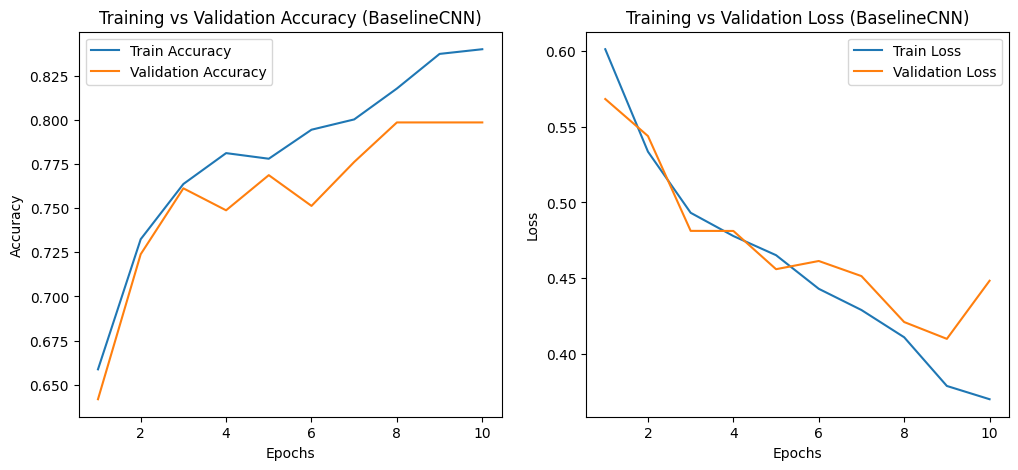

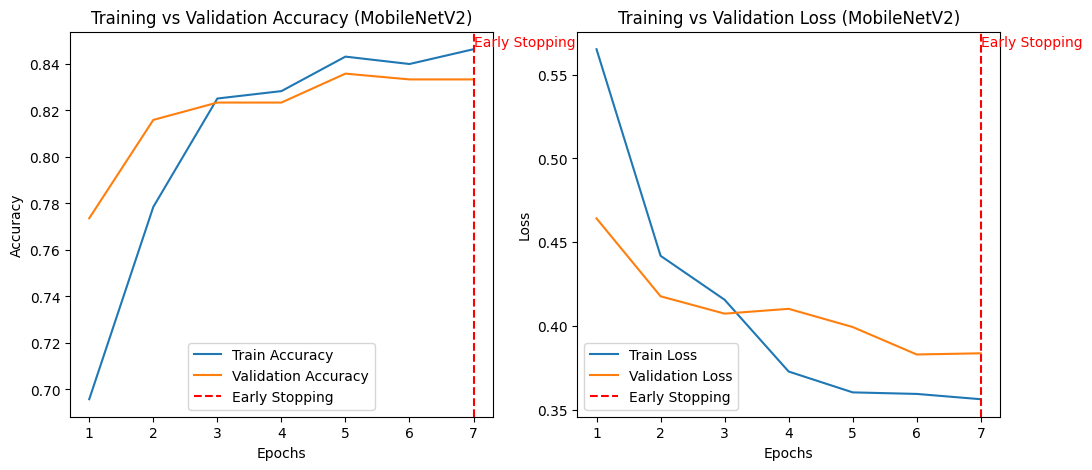

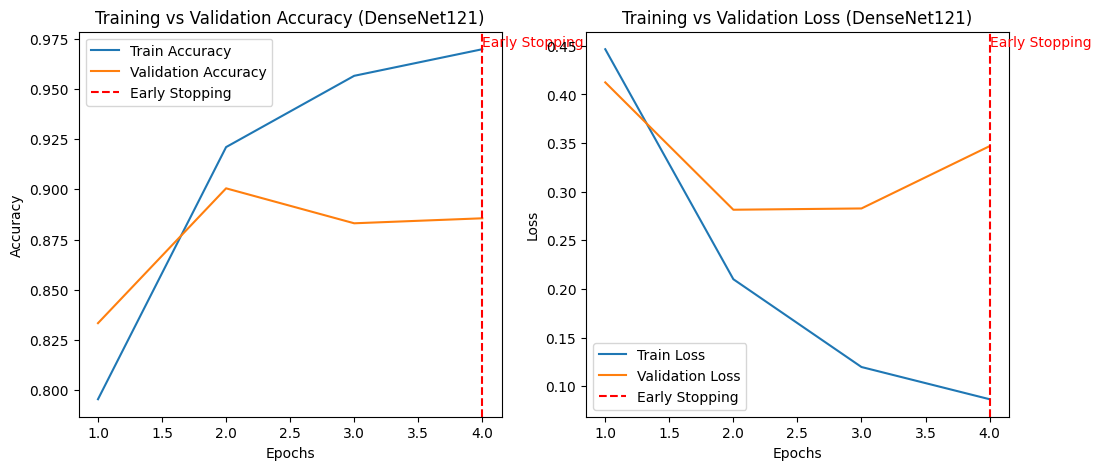

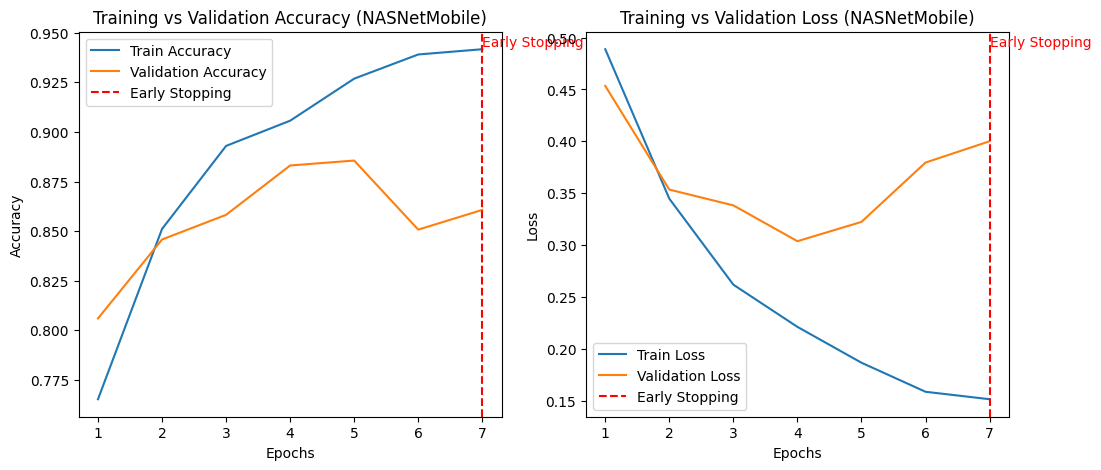

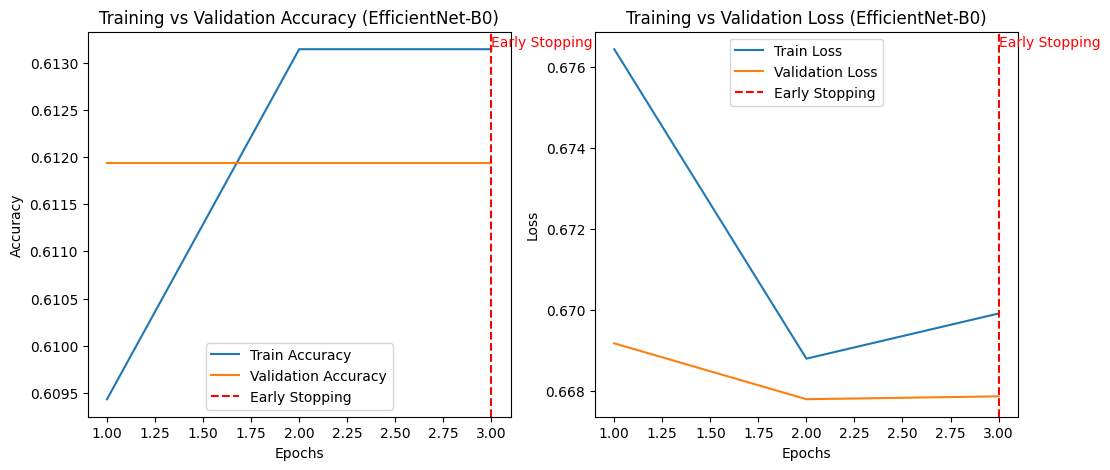

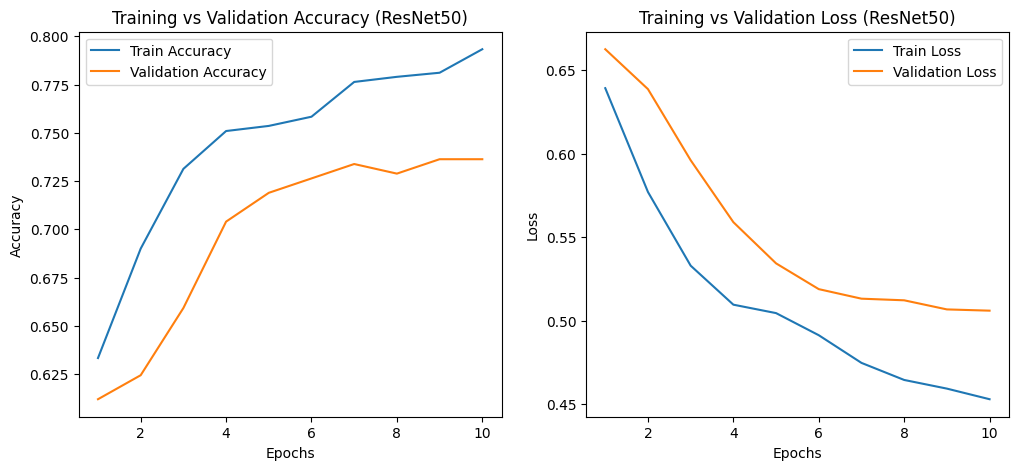

In [15]:
# Model history paths
model_histories = {
    "BaselineCNN": "/kaggle/input/baselinecnn/saved_models/best_history.json",
    "MobileNetV2": "/kaggle/input/mobilenetv2/saved_models/best_history.json",
    "DenseNet121": "/kaggle/input/densenet121/saved_models/best_history.json",
    "NASNetMobile": "/kaggle/input/nasnetmobile/saved_models/best_history.json",
    "EfficientNet-B0": "/kaggle/input/efficientnet-b0/saved_models/best_history.json",
    "ResNet50": "/kaggle/input/resnet50/saved_models/best_history.json",
}

# Plot overfitting graphs for all models
for model_name, history_path in model_histories.items():
    history = load_history(history_path)
    plot_overfitting_graph(history, model_name)

In [16]:
# Function to extract a fixed Type I (False Positive) and Type II (False Negative) error
def get_fixed_misclassified_samples(model, test_ds, class_labels=["Fire", "No Fire"], seed=42):
    """Extracts a fixed False Positive (Type I) and False Negative (Type II) error with probabilities."""
    np.random.seed(seed)  # Fix randomness for consistency

    false_positives, false_negatives = [], []
    false_positive_images, false_negative_images = [], []

    for images, labels in test_ds:
        y_pred_probs = model.predict(images, verbose=0).flatten()
        y_pred = (y_pred_probs >= 0.5).astype(int)
        y_true = labels.numpy().flatten()

        for i in range(len(images)):
            if y_true[i] == 1 and y_pred[i] == 0:  # Type II Error (False Negative)
                false_negatives.append({
                    "True Label": class_labels[1],  # "No Fire"
                    "Predicted Label": class_labels[0],  # "Fire"
                    "Probability": f"{y_pred_probs[i]:.2f}"
                })
                false_negative_images.append(images[i].numpy())

            elif y_true[i] == 0 and y_pred[i] == 1:  # Type I Error (False Positive)
                false_positives.append({
                    "True Label": class_labels[0],  # "Fire"
                    "Predicted Label": class_labels[1],  # "No Fire"
                    "Probability": f"{y_pred_probs[i]:.2f}"
                })
                false_positive_images.append(images[i].numpy())

    # Fix sample selection to always pick the same image
    if false_positives and false_negatives:
        selected_fp_idx = np.random.choice(len(false_positives), 1)[0]
        selected_fn_idx = np.random.choice(len(false_negatives), 1)[0]

        return (
            false_positives[selected_fp_idx], false_negatives[selected_fn_idx], 
            false_positive_images[selected_fp_idx], false_negative_images[selected_fn_idx]
        )

    return None, None, None, None

# Function to display a fixed Type I and Type II error for DenseNet121
def display_fixed_misclassified_samples(model, test_ds, model_name="DenseNet121", class_labels=["Fire", "No Fire"]):
    """Displays a fixed False Positive (Type I) and False Negative (Type II) with better spacing."""
    false_positive, false_negative, false_positive_image, false_negative_image = get_fixed_misclassified_samples(model, test_ds, class_labels)

    if false_positive is None or false_negative is None:
        print(f"Not enough misclassified samples found for {model_name}.")
        return

    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to display format
    image_fp = (false_positive_image * 255).astype(np.uint8)
    image_fn = (false_negative_image * 255).astype(np.uint8)

    # Display False Positive (Type I Error)
    axes[0].imshow(image_fp)
    axes[0].axis("off")
    axes[0].set_title(
        f"False Positive (Type I Error)\n"
        f"True Label: {false_positive['True Label']} | Predicted: {false_positive['Predicted Label']}\n"
        f"Probability: {false_positive['Probability']}",
        fontsize=11, loc="center"
    )

    # Display False Negative (Type II Error)
    axes[1].imshow(image_fn)
    axes[1].axis("off")
    axes[1].set_title(
        f"False Negative (Type II Error)\n"
        f"True Label: {false_negative['True Label']} | Predicted: {false_negative['Predicted Label']}\n"
        f"Probability: {false_negative['Probability']}",
        fontsize=11, loc="center"
    )

    # Adjust the layout for better spacing
    fig.suptitle(f"Misclassified Samples - {model_name}", fontsize=15)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.05)  # Balanced spacing
    plt.show()

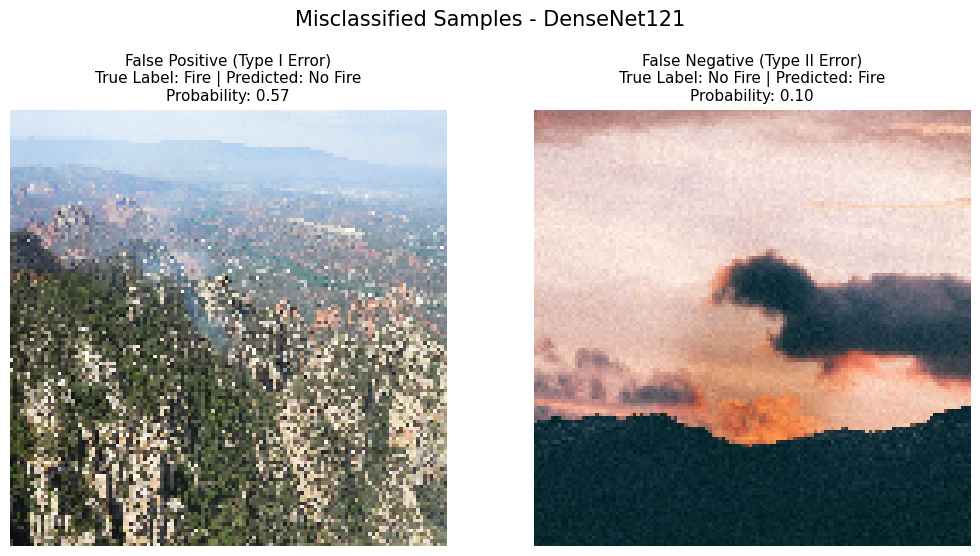

In [17]:
densenet121_model = tf.keras.models.load_model(model_paths['DenseNet121'])
display_fixed_misclassified_samples(densenet121_model, test_ds)

In [18]:
# Function to extract one correctly classified sample for each class (Fire and No Fire)
def get_correctly_classified_samples_per_class(model, test_ds, class_labels=["Fire", "No Fire"], seed=1234):
    """Extracts one correctly classified sample for each class (Fire and No Fire) with probabilities."""
    np.random.seed(seed)  # Fix randomness for consistency

    fire_correct = None
    no_fire_correct = None
    fire_correct_image = None
    no_fire_correct_image = None

    for images, labels in test_ds:
        y_pred_probs = model.predict(images, verbose=0).flatten()
        y_pred = (y_pred_probs >= 0.5).astype(int)
        y_true = labels.numpy().flatten()

        for i in range(len(images)):
            if int(y_true[i]) == int(y_pred[i]):  # Correct Classification
                if int(y_true[i]) == 0 and fire_correct is None:  # Fire correctly classified
                    fire_correct = {
                        "True Label": class_labels[int(y_true[i])],
                        "Predicted Label": class_labels[int(y_pred[i])],
                        "Probability": f"{y_pred_probs[i]:.2f}"
                    }
                    fire_correct_image = images[i].numpy()

                elif int(y_true[i]) == 1 and no_fire_correct is None:  # No Fire correctly classified
                    no_fire_correct = {
                        "True Label": class_labels[int(y_true[i])],
                        "Predicted Label": class_labels[int(y_pred[i])],
                        "Probability": f"{y_pred_probs[i]:.2f}"
                    }
                    no_fire_correct_image = images[i].numpy()

            # Stop once we have one correct example per class
            if fire_correct and no_fire_correct:
                return fire_correct, no_fire_correct, fire_correct_image, no_fire_correct_image

    return None, None, None, None

# Function to display one correctly classified Fire and No Fire sample
def display_correctly_classified_samples(model, test_ds, model_name="DenseNet121", class_labels=["Fire", "No Fire"]):
    """Displays one correctly classified sample for each class with its prediction confidence."""
    fire_correct, no_fire_correct, fire_correct_image, no_fire_correct_image = get_correctly_classified_samples_per_class(model, test_ds, class_labels)

    if fire_correct is None or no_fire_correct is None:
        print(f"Not enough correctly classified samples found for {model_name}.")
        return

    # Convert images to display format
    fire_correct_image = (fire_correct_image * 255).astype(np.uint8)
    no_fire_correct_image = (no_fire_correct_image * 255).astype(np.uint8)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display correctly classified Fire image
    axes[0].imshow(fire_correct_image)
    axes[0].axis("off")
    axes[0].set_title(
        f"Correctly Classified Fire\n"
        f"True Label: {fire_correct['True Label']} | Predicted: {fire_correct['Predicted Label']}\n"
        f"Probability: {fire_correct['Probability']}",
        fontsize=11, loc="center"
    )

    # Display correctly classified No Fire image
    axes[1].imshow(no_fire_correct_image)
    axes[1].axis("off")
    axes[1].set_title(
        f"Correctly Classified No Fire\n"
        f"True Label: {no_fire_correct['True Label']} | Predicted: {no_fire_correct['Predicted Label']}\n"
        f"Probability: {no_fire_correct['Probability']}",
        fontsize=11, loc="center"
    )

    # Adjust layout for better spacing
    fig.suptitle(f"Correctly Classified Samples - {model_name}", fontsize=15)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.05)  # Balanced spacing
    plt.show()

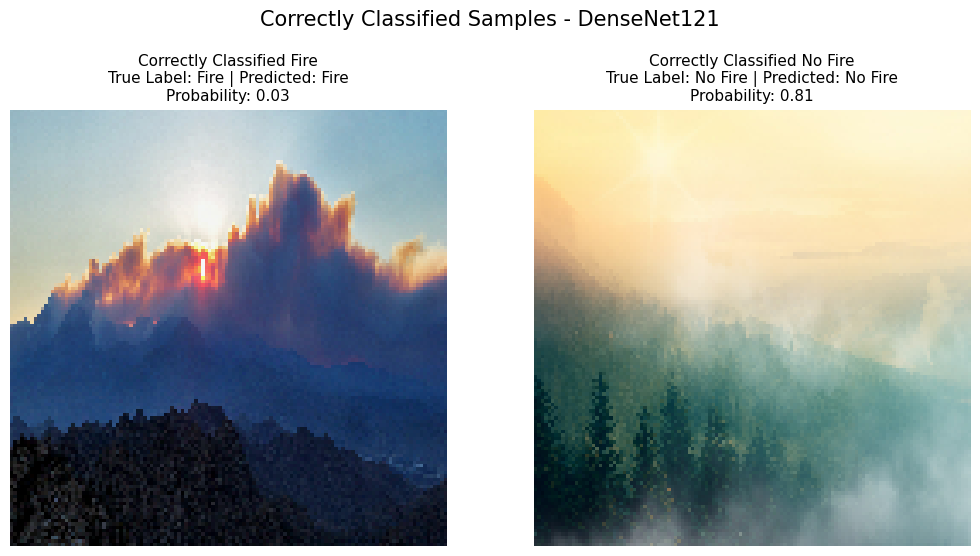

In [19]:
display_correctly_classified_samples(densenet121_model, test_ds)

In [20]:
# Function to compute and plot ROC curves for all models
def plot_roc_curves(model_paths, test_ds):
    plt.figure(figsize=(10, 8))

    for model_name, model_path in model_paths.items():
        print(f"Processing {model_name}...")  # Indicate processing
        model = tf.keras.models.load_model(model_path)

        # Collect true labels and predictions
        y_true_list, y_pred_probs_list = [], []
        for images, labels in test_ds:
            y_true_list.append(labels.numpy())
            y_pred_probs_list.append(model.predict(images, verbose=0))

        y_true = np.concatenate(y_true_list, axis=0)
        y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)

        # Compute ROC curve
        fnr, tnr, _ = roc_curve(y_true, y_pred_probs)
        roc_auc = auc(fnr, tnr)

        # Plot ROC curve
        plt.plot(fnr, tnr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    # Plot formatting
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.show()

Processing BaselineCNN...
Processing MobileNetV2...
Processing DenseNet121...
Processing NASNetMobile...
Processing EfficientNet-B0...
Processing ResNet50...


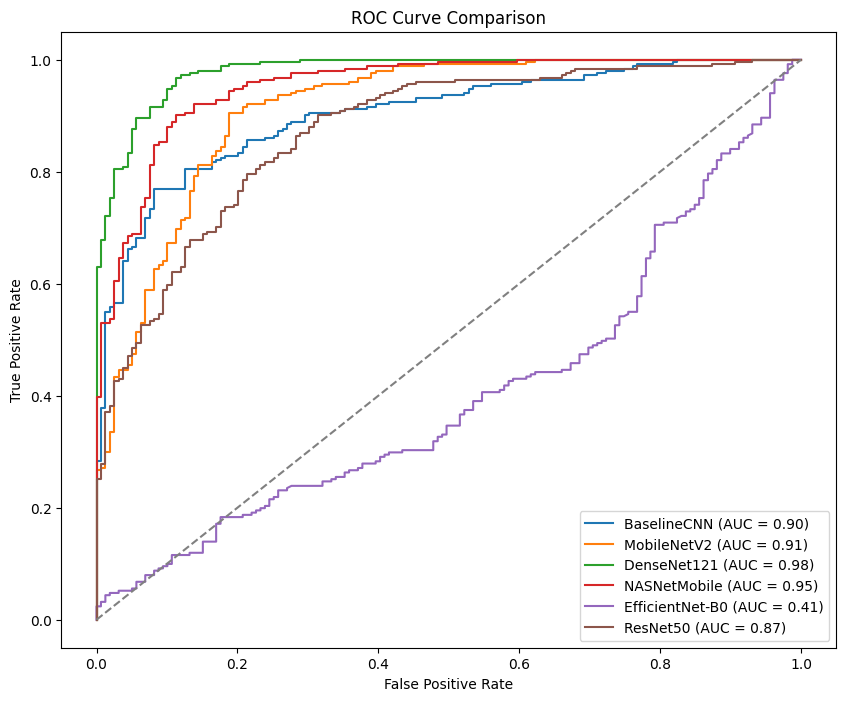

In [21]:
# Plot ROC curves for all models
plot_roc_curves(model_paths, test_ds)